# 03 - MIP Solver

This notebook implements a Mixed Integer Programming (MIP) approach to solve the Tourist Trip Design Problem (TTDP).

## Goal
Use an exact optimization method (MIP) to find the mathematically optimal itinerary solution. This serves as a benchmark for evaluating the GA's performance.

## Expected Outcome
The proven optimal solution for a smaller subset of POIs. Due to computational complexity, MIP cannot handle the full dataset but provides valuable insights for comparison.

### Step 1: Import Libraries and Load Data

Load the subset of POIs prepared specifically for MIP optimization.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

sys.path.append('../src')
from mip_solver import MIPSolverTTDP

In [2]:
# Load preprocessed subset data (top 20 POIs)
pois_subset = pd.read_csv('../data/processed/pois_subset_mip.csv')
travel_time_matrix_subset = np.load('../data/processed/travel_time_matrix_subset.npy')

print(f"Loaded {len(pois_subset)} POIs for MIP solver")
print(f"Travel time matrix shape: {travel_time_matrix_subset.shape}")
print(f"\nTop POIs selected:")
print(pois_subset[['name', 'category', 'interest_score', 'visit_duration']].head(10))

Loaded 20 POIs for MIP solver
Travel time matrix shape: (20, 20)

Top POIs selected:
                                          name     category  interest_score  \
0                       Kirigalpottha Mountain  HikesnViews             100   
1  Temple of the Tooth Relic (Dalada Maligawa)     Cultural             100   
2      Namal Uyana - The Rose Quartz Mountains     Wildlife             100   
3                  Lunugamvehera National Park     Wildlife             100   
4                        Galle Fort (Entrance)     Cultural             100   
5                               Kande Viharaya     Cultural             100   
6                   Hike up Narangala Mountain  HikesnViews             100   
7                              Kabaragala Rock  HikesnViews             100   
8                Atadage - Polonnaruwa Kingdom     Cultural             100   
9                  Galway's Land National Park     Wildlife             100   

   visit_duration  
0             3.0  
1    

### Step 2: Configure MIP Problem

Define the same trip constraints as the GA for fair comparison.

In [3]:
# Problem parameters
NUM_DAYS = 3
MAX_TIME_PER_DAY = 8  # hours
TIME_LIMIT = 300  # seconds (5 minutes max solver time)

print("MIP Problem Configuration:")
print(f"  Number of POIs: {len(pois_subset)}")
print(f"  Number of days: {NUM_DAYS}")
print(f"  Max time per day: {MAX_TIME_PER_DAY} hours")
print(f"  Solver time limit: {TIME_LIMIT} seconds")

MIP Problem Configuration:
  Number of POIs: 20
  Number of days: 3
  Max time per day: 8 hours
  Solver time limit: 300 seconds


### Step 3: Formulate and Solve MIP Problem

**Mathematical Formulation:**

**Objective:** Maximize total interest score

**Decision Variables:**
- y[i,d]: Binary, 1 if POI i is visited on day d
- x[i,j,d]: Binary, 1 if traveling from POI i to POI j on day d
- u[i,d]: Continuous, position of POI i in sequence on day d (subtour elimination)

**Key Constraints:**
1. Visit each POI at most once
2. Flow conservation (arrive = depart)
3. Daily time budget (travel + visit ≤ T_max)
4. Subtour elimination (Miller-Tucker-Zemlin)

In [4]:
# Create MIP solver instance
mip_solver = MIPSolverTTDP(
    pois_df=pois_subset,
    travel_time_matrix=travel_time_matrix_subset,
    num_days=NUM_DAYS,
    max_time_per_day=MAX_TIME_PER_DAY,
    time_limit=TIME_LIMIT
)

print("MIP solver initialized successfully!")

MIP solver initialized successfully!


In [5]:
# Solve the MIP problem
print("Solving TTDP using Mixed-Integer Programming...")
print("=" * 50)

start_time = time.time()
mip_itinerary, mip_score, mip_status = mip_solver.solve(verbose=True)
end_time = time.time()

print("=" * 50)
print(f"\nMIP solver completed in {end_time - start_time:.2f} seconds")
print(f"Solution status: {mip_status}")
print(f"Optimal score: {mip_score:.1f}")
print(f"Number of days used: {len(mip_itinerary)}")

Solving TTDP using Mixed-Integer Programming...
Starting MIP solver...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jam/serendip-travel/tourist-trip-optimizer/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/329f09402d2d4c65aeb6a07a02f5eb0f-pulp.mps -max -sec 300 -timeMode elapsed -branch -printingOptions all -solution /var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/329f09402d2d4c65aeb6a07a02f5eb0f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1360 COLUMNS
At line 11804 RHS
At line 13160 BOUNDS
At line 14604 ENDATA
Problem MODEL has 1355 rows, 1443 columns and 7617 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 300
Option for timeMode changed from cpu to elapsed
Continuous objective value is 774.114 - 0.00 seconds
Cgl0002I 63 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 1140 strengthe

### Step 4: Analyze the Optimal Solution

Display the mathematically proven optimal itinerary.

In [6]:
# Display the optimal itinerary
print("\n" + "="*70)
print("OPTIMAL ITINERARY (MIP Solver)")
print("="*70)

if mip_status in ['Optimal', 'Feasible']:
    total_score = 0
    for day_idx, day_route in enumerate(mip_itinerary, 1):
        print(f"\nDay {day_idx}:")
        print("-" * 70)
        
        day_score = 0
        day_visit_time = 0
        day_travel_time = 0
        
        for poi_order, poi_idx in enumerate(day_route, 1):
            poi_info = pois_subset.iloc[poi_idx]
            day_score += poi_info['interest_score']
            day_visit_time += poi_info['visit_duration']
            
            # Calculate travel time from previous POI
            if poi_order > 1:
                prev_poi_idx = day_route[poi_order - 2]
                day_travel_time += travel_time_matrix_subset[prev_poi_idx, poi_idx]
            
            print(f"  {poi_order}. {poi_info['name']}")
            print(f"     Category: {poi_info['category']} | Score: {poi_info['interest_score']} | Duration: {poi_info['visit_duration']}h")
        
        day_total_time = day_visit_time + day_travel_time
        total_score += day_score
        
        print(f"\n  Day {day_idx} Summary:")
        print(f"    POIs visited: {len(day_route)}")
        print(f"    Score: {day_score}")
        print(f"    Visit time: {day_visit_time:.2f}h")
        print(f"    Travel time: {day_travel_time:.2f}h")
        print(f"    Total time: {day_total_time:.2f}h / {MAX_TIME_PER_DAY}h")
    
    print("\n" + "="*70)
    print(f"TOTAL TRIP SCORE: {total_score}")
    print(f"TOTAL POIs VISITED: {sum(len(day) for day in mip_itinerary)}")
    print("="*70)
else:
    print(f"\nNo feasible solution found. Status: {mip_status}")


OPTIMAL ITINERARY (MIP Solver)

Day 1:
----------------------------------------------------------------------
  1. Kabaragala Rock
     Category: HikesnViews | Score: 100 | Duration: 3.0h

  Day 1 Summary:
    POIs visited: 1
    Score: 100
    Visit time: 3.00h
    Travel time: 0.00h
    Total time: 3.00h / 8h

Day 2:
----------------------------------------------------------------------
  1. Ambuluwawa Temple
     Category: Cultural | Score: 100 | Duration: 3.0h

  Day 2 Summary:
    POIs visited: 1
    Score: 100
    Visit time: 3.00h
    Travel time: 0.00h
    Total time: 3.00h / 8h

Day 3:
----------------------------------------------------------------------
  1. Galway's Land National Park
     Category: Wildlife | Score: 100 | Duration: 3.0h
  2. Hike up Narangala Mountain
     Category: HikesnViews | Score: 100 | Duration: 3.0h

  Day 3 Summary:
    POIs visited: 2
    Score: 200
    Visit time: 6.00h
    Travel time: 0.63h
    Total time: 6.63h / 8h

TOTAL TRIP SCORE: 400
TO

### Step 5: Visualize Solution Distribution

Visual analysis of the optimal solution structure.

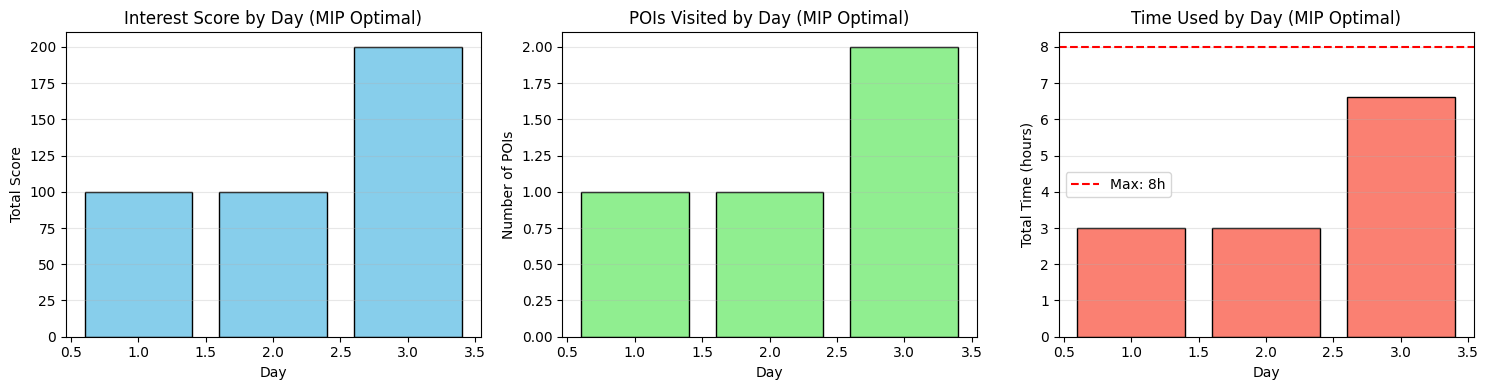

In [7]:
if mip_status in ['Optimal', 'Feasible']:
    # Calculate metrics per day
    day_scores = []
    day_pois = []
    day_times = []
    
    for day_route in mip_itinerary:
        day_score = sum(pois_subset.iloc[poi_idx]['interest_score'] for poi_idx in day_route)
        day_visit_time = sum(pois_subset.iloc[poi_idx]['visit_duration'] for poi_idx in day_route)
        day_travel_time = sum(travel_time_matrix_subset[day_route[i], day_route[i+1]] 
                             for i in range(len(day_route)-1))
        
        day_scores.append(day_score)
        day_pois.append(len(day_route))
        day_times.append(day_visit_time + day_travel_time)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Score per day
    axes[0].bar(range(1, len(mip_itinerary)+1), day_scores, color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Total Score')
    axes[0].set_title('Interest Score by Day (MIP Optimal)')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # POIs per day
    axes[1].bar(range(1, len(mip_itinerary)+1), day_pois, color='lightgreen', edgecolor='black')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Number of POIs')
    axes[1].set_title('POIs Visited by Day (MIP Optimal)')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Time per day
    axes[2].bar(range(1, len(mip_itinerary)+1), day_times, color='salmon', edgecolor='black')
    axes[2].axhline(y=MAX_TIME_PER_DAY, color='red', linestyle='--', label=f'Max: {MAX_TIME_PER_DAY}h')
    axes[2].set_xlabel('Day')
    axes[2].set_ylabel('Total Time (hours)')
    axes[2].set_title('Time Used by Day (MIP Optimal)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

### Step 6: Save Results

Save the MIP solution for comparison with GA.

In [8]:
# Save results
import json
import os

os.makedirs('../results', exist_ok=True)

results = {
    'method': 'Mixed-Integer Programming',
    'total_score': float(mip_score),
    'num_days': len(mip_itinerary),
    'total_pois': sum(len(day) for day in mip_itinerary),
    'computation_time': end_time - start_time,
    'status': mip_status,
    'itinerary': [[int(poi_idx) for poi_idx in day] for day in mip_itinerary],
    'num_pois_in_problem': len(pois_subset)
}

with open('../results/mip_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to ../results/mip_results.json")

Results saved to ../results/mip_results.json


### Summary

**Completed Steps:**
1. ✓ Loaded subset POI data (top 20 POIs)
2. ✓ Formulated MIP problem with full constraints
3. ✓ Solved using CBC solver
4. ✓ Analyzed optimal solution
5. ✓ Visualized solution structure
6. ✓ Saved results for comparison

**Key Findings:**
- MIP provides proven optimal solution for small problem instances
- Solution respects all constraints (time budget, flow conservation, etc.)
- Computational time increases drastically with problem size
- Not scalable to full dataset (1000+ POIs)

**Next Steps:**
Proceed to notebook 04 for results comparison and analysis.